In [5]:
#Importing required Libraries and Packages
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.signal import butter, lfilter
from fastdtw import fastdtw
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from numpy.fft import fft, fftfreq 

In [3]:
# Reading the data file
data = pd.read_csv("C:\\Users\\munis\\Downloads\\Epileptic Seizure Recognition.csv\\Epileptic Seizure Recognition.csv")

In [3]:
print(data.head())

      Unnamed   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11500 entries, 0 to 11499
Columns: 180 entries, Unnamed to y
dtypes: int64(179), object(1)
memory usage: 15.8+ MB
None


In [4]:
#Describing the data points
print(data.describe())

                 X1            X2            X3            X4            X5  \
count  11500.000000  11500.000000  11500.000000  11500.000000  11500.000000   
mean     -11.581391    -10.911565    -10.187130     -9.143043     -8.009739   
std      165.626284    166.059609    163.524317    161.269041    160.998007   
min    -1839.000000  -1838.000000  -1835.000000  -1845.000000  -1791.000000   
25%      -54.000000    -55.000000    -54.000000    -54.000000    -54.000000   
50%       -8.000000     -8.000000     -7.000000     -8.000000     -8.000000   
75%       34.000000     35.000000     36.000000     36.000000     35.000000   
max     1726.000000   1713.000000   1697.000000   1612.000000   1518.000000   

                 X6            X7           X8           X9           X10  \
count  11500.000000  11500.000000  11500.00000  11500.00000  11500.000000   
mean      -7.003478     -6.502087     -6.68713     -6.55800     -6.168435   
std      161.328725    161.467837    162.11912    162.033

In [6]:
#Checking for null values
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Unnamed    0
X1         0
X2         0
X3         0
X4         0
          ..
X175       0
X176       0
X177       0
X178       0
y          0
Length: 180, dtype: int64


In [7]:
X = data.iloc[:, 1:-1].values.astype(float)  # Excluding the first (identity) and last (label) columns
y = data.iloc[:, -1].values

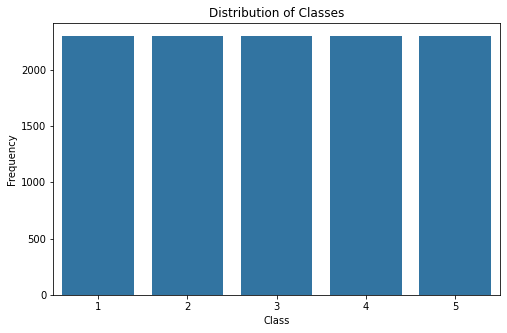

In [8]:
# Plotting class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=y)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Checking for class imbalance
print("Class distribution:\n", pd.Series(y).value_counts())

Class distribution:
 4    2300
1    2300
5    2300
2    2300
3    2300
Name: count, dtype: int64


In [10]:
# Defining a function to apply a Butterworth bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = np.array(data, dtype=np.float32)
    y = lfilter(b, a, data)
    return y

In [11]:
# Applying the bandpass filter to remove noise
fs = 178  
lowcut = 0.5
highcut = 45.0

X_filtered = np.array([butter_bandpass_filter(x, lowcut, highcut, fs) for x in X])

In [12]:
X_filtered

array([[  7.12616461,  45.02586062, 124.47692469, ..., -86.12020514,
        -95.17979838, -70.34919623],
       [ 20.37555214, 120.22831241, 298.33707772, ..., 103.67532912,
         94.58604602,  79.59483588],
       [ -1.68916494, -10.35412311, -27.55627946, ..., -25.80434545,
        -41.58772144, -43.68190266],
       ...,
       [  0.73900966,   3.94597926,   7.41646442, ...,  18.43287515,
         44.46775062,  70.40109452],
       [ -2.11145618, -11.68897678, -25.66244393, ...,  82.58055707,
         45.07145732,  21.98900583],
       [  1.53080573,   9.68199717,  27.19961859, ...,  15.62199713,
         13.72176774,  12.9524396 ]])

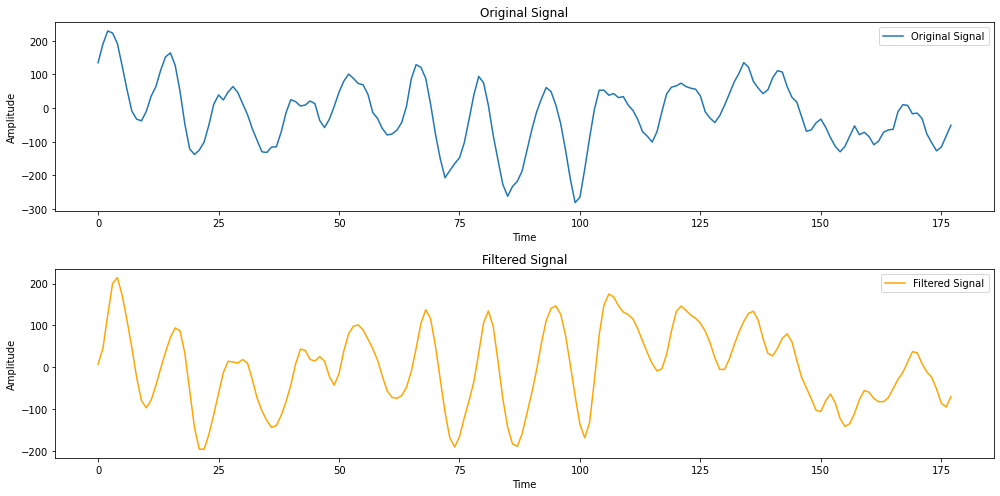

In [13]:
index = 0

# Plot original vs. filtered signal for the first value
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(X[index], label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(X_filtered[index], label='Filtered Signal', color='orange')
plt.title('Filtered Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()

plt.tight_layout()
plt.show()

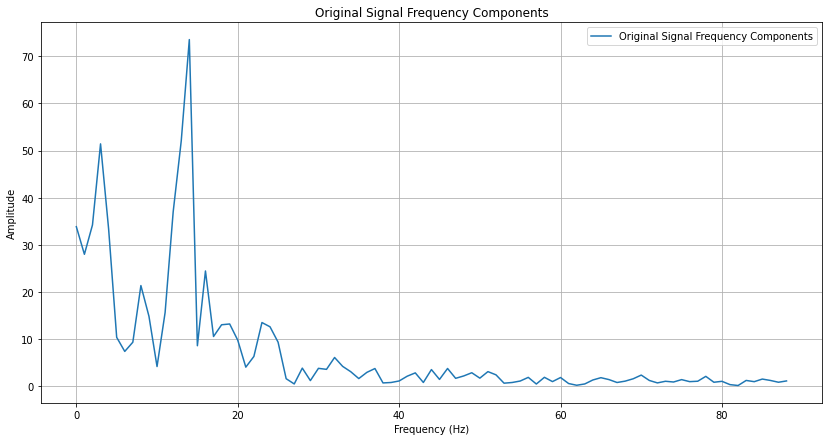

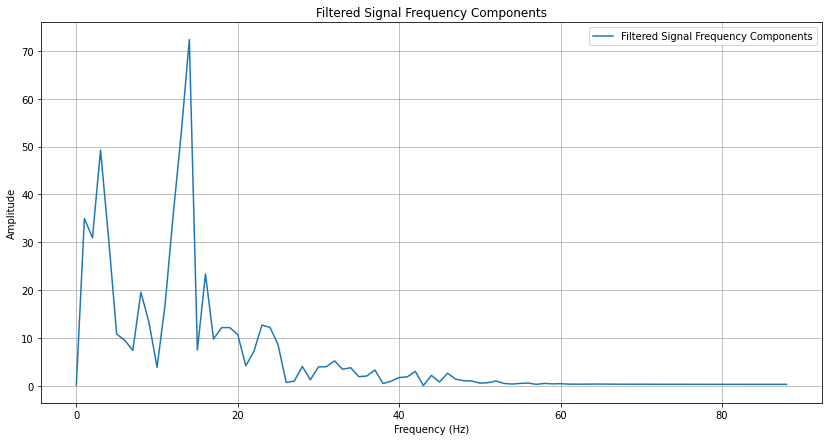

In [14]:
# Performing Fourier Transform to analyze frequency components
def plot_frequency_analysis(data, title, fs):
    N = len(data)
    T = 1.0 / fs
    yf = fft(data)
    xf = fftfreq(N, T)[:N//2]

    plt.figure(figsize=(14, 7))
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]), label=title)
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.legend()
    plt.show()

plot_frequency_analysis(X[index], 'Original Signal Frequency Components', fs)
plot_frequency_analysis(X_filtered[index], 'Filtered Signal Frequency Components', fs)


In [15]:
# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

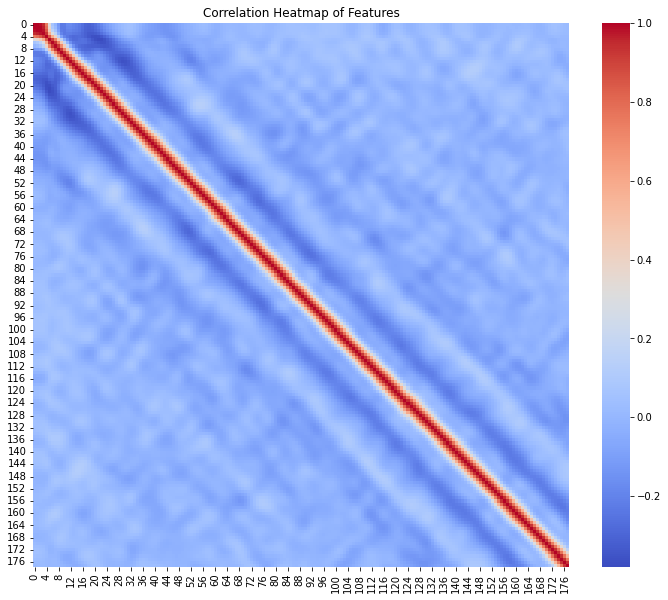

In [16]:
# Ploting correlation heatmap (if applicable)
plt.figure(figsize=(12, 10))
corr_matrix = pd.DataFrame(X_scaled).corr()
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

In [17]:
# Splitting the data into training and testing sets into 70:30 respectively
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [18]:
# Converting the problem to binary classification (1 = seizure, 0 = non-seizure)
y_train = (y_train == 1).astype(int)
y_test = (y_test == 1).astype(int)

In [19]:
# Function to extract DTW features
def extract_dtw_features(X, reference_sequence, sequence_length):
    dtw_features = []
    reference_sequence = np.asarray(reference_sequence, dtype=np.float64).ravel()

    for sequence in X:
        sequence = np.asarray(sequence, dtype=np.float64).ravel()

        # Compute the DTW distance
        distance, _ = fastdtw(sequence, reference_sequence, dist=2)

        # Create fixed-size sequences for CNN input
        dtw_sequence = np.full(sequence_length, distance)
        dtw_features.append(dtw_sequence)

    return np.array(dtw_features)

In [20]:
# Selecting a reference sequence (e.g., the mean of the training set)
reference_sequence = np.mean(X_train, axis=0)

In [22]:
# Setting a sequence length for CNN input
sequence_length = 10

In [23]:
# Extracting DTW features for training and testing sets
X_train_dtw = extract_dtw_features(X_train, reference_sequence, sequence_length)
X_test_dtw = extract_dtw_features(X_test, reference_sequence, sequence_length)

# Reshaping for CNN-LSTM model input
X_train_dtw = X_train_dtw.reshape(-1, sequence_length, 1)
X_test_dtw = X_test_dtw.reshape(-1, sequence_length, 1)

# Defining the CNN-LSTM model for binary classification
model = Sequential()

In [24]:
# Adding convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

In [25]:
# Adding LSTM layers
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))

In [26]:
# Fully connected layer
model.add(Dense(1, activation='sigmoid'))

In [27]:
# Compiling the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [28]:
# Callbacks for learning rate adjustment and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [29]:
# Training the model
history = model.fit(X_train_dtw, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

Epoch 1/50
202/202 [==============================] - 4s 8ms/step - loss: 0.1626 - accuracy: 0.9446 - val_loss: 0.1177 - val_accuracy: 0.9522 - lr: 0.0010
Epoch 2/50
202/202 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9488 - val_loss: 0.2381 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/50
202/202 [==============================] - 1s 5ms/step - loss: 0.1441 - accuracy: 0.9433 - val_loss: 0.1773 - val_accuracy: 0.9404 - lr: 0.0010
Epoch 4/50
202/202 [==============================] - 1s 5ms/step - loss: 0.1285 - accuracy: 0.9512 - val_loss: 0.1244 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 5/50
202/202 [==============================] - 1s 5ms/step - loss: 0.1377 - accuracy: 0.9461 - val_loss: 0.1626 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 6/50
202/202 [==============================] - 1s 6ms/step - loss: 0.1382 - accuracy: 0.9478 - val_loss: 0.1144 - val_accuracy: 0.9584 - lr: 0.0010
Epoch 7/50
202/202 [==============================] - 1s 5ms/step - lo

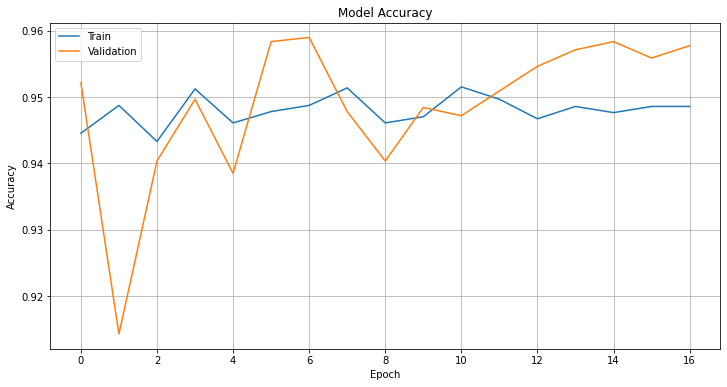

In [30]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

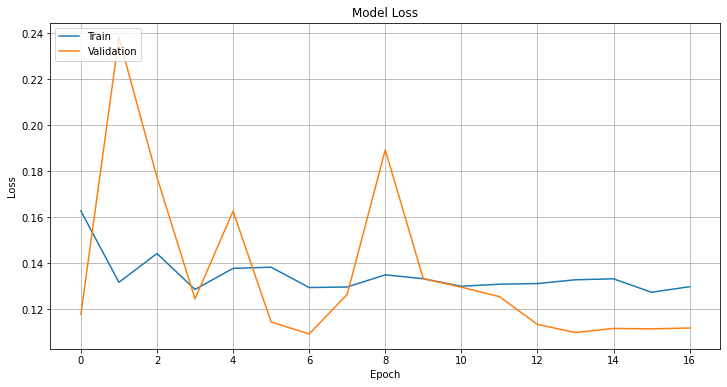

In [31]:
# Plotting training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.grid()
plt.show()

In [32]:
# Evaluating the model
loss, accuracy = model.evaluate(X_test_dtw, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

108/108 [==============================] - 0s 2ms/step - loss: 0.1016 - accuracy: 0.9562
Test Accuracy: 95.62%


In [33]:
# Predictions
y_pred = model.predict(X_test_dtw)
y_pred = (y_pred > 0.5).astype(int)

In [34]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

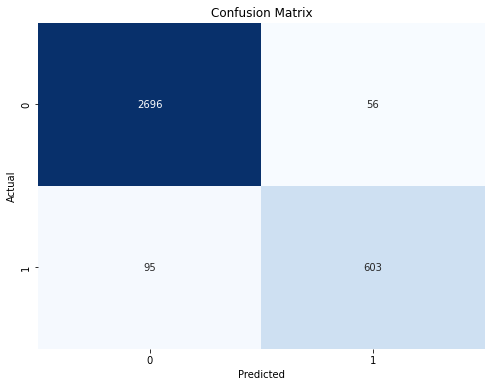

In [35]:
# Plotting confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [36]:
# Performance metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2752
           1       0.92      0.86      0.89       698

    accuracy                           0.96      3450
   macro avg       0.94      0.92      0.93      3450
weighted avg       0.96      0.96      0.96      3450

